**Don Smith - Neural Network Implementation 'From Scratch'**

In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

random.seed(42)

In [2]:
# Read dataset
data = pd.read_csv('fashion_data.csv')

In [3]:
# Data pre-processing
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # Shuffle before splitting into dev and training sets

data_dev = data[0:400].T
Y_dev = data_dev[-1]
X_dev = data_dev[0:n-1]
X_dev = X_dev / 255.

data_train = data[400:m].T
Y_train = data_train[-1]
X_train = data_train[0:n-1]
X_train = X_train / 255.
_,m_train = X_train.shape

**Building a Neural Network from Scratch**

In [8]:
# Define a global variable specifying the number of hidden neurons after the first layer
# Generally this is not best practice, but we'll do it for the purposes of this from-scratch exercise
num_hidden_neurons = 20

In [9]:
# Initialize the parameters in the neural network

# I need to generate the weight and bias matrices 
# W1 and b1 are the matrices for the first layer
# W2 and b2 are the matrices for the second layer

def init_params():
    W1 = np.random.uniform(low=-0.5, high=0.5, size=(num_hidden_neurons, 784))  # Set boundaries for random draw, rows = # of neurons, 784 columns to match # of vectors per image
    b1 = np.random.uniform(low=-0.5, high=0.5, size=(num_hidden_neurons, 1))  # Rows = # of neurons, 1 column because the bias vector is a column vector
    W2 = np.random.uniform(low=-0.5, high=0.5, size=(10, num_hidden_neurons))  # Rows = # of item categories, columns = # of neurons in the hidden layer
    b2 = np.random.uniform(low=-0.5, high=0.5, size=(10, 1))  # Rows = # of item categories, 1 column because the bias vector is a column vector
    return W1, b1, W2, b2

In [10]:
# Implement the non-linearity functions and their derivatives
def ReLU(Z):
    # Relu activation function
    return np.maximum(0, Z)  # Per the text

def ReLU_deriv(Z):
    # Relu derivative function
    Z[Z<=0] = 0
    Z[Z>0] = 1
    return Z

def softmax(Z):
    """
    Per https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    And per https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78
    A softmax function exponentiates each element of the input matrix and normalizes the values by dividing each value by the sum of all values.
    This makes the resulting values representative of probabilities which sum to 1.
    """
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [11]:
# Implement the forward propagation function

# In the forward propagation function, X is the inputs (the image in vector form), and we pass all the weights and biases
# We use ReLU in the hidden layers to introduce nonlinearity, and softmax at the output layer to convert to probabilistic-type values

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1  # We have: (weighted sum of inputs * weights) + bias terms
    A1 = ReLU(Z1)  # Activations of the neurons in hidden layer after applying the ReLU function to the Z1 matrix
    Z2 = W2.dot(A1) + b2  # Parallel process to computation of Z1, but for the output layer
    A2 = softmax(Z2)  # Activations of the neurons in the output layer after applying the softmax function to the Z2 matrix
    return Z1, A1, Z2, A2

In [12]:
# Implement the backward propagation function
def one_hot(Y):
    """
    This 'one hot' function converts a numeric number into a one-hot vector
    We're working with the known labels here. So, to create a by-hand one-hot encoder, we need to do the following:
    - Instantiate a matrix initially filled with the "off" value (0) which has rows = # of examples and columns = # of categories/labels
    - Find the column of the matrix which corresponds to the known label (i.e. the 'true' column) and set it to 1
    - Transpose the result so it matches the shape we need, which is rows = # of categories/labels and columns = # of examples
    """
    # Define number of actual occurring/present categories programatically
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))  # Creates a zero-filled matrix where rows = Y.size (# of examples) and columns = Y.max() + 1 (# of categories/labels.) 
                                                 # I need to supply the + 1 is because the columns are zero-indexed.
    
    '''
    Setting the value equal to 1 in the correct column is complicated. What we do is:
    - Fetch the correct matrix index in the one_hot_Y matrix by parsing it to find:
        1. The first index value, corresponding to the array of index values representative of the total # of examples, given by np.arange(Y.size).
        2. The second index value, corresponding to the column in the one_hot_Y matrix which represents the correct 'known' label, given by the input Y.
    - At those matrix index values, change the zero to a 1.
    - This one-hot encodes the correct 'known' column for each example in the matrix with a 1. 
    '''
    one_hot_Y[np.arange(Y.size), Y] = 1
    
    one_hot_Y = one_hot_Y.T  # Transpose the matrix
    
    return one_hot_Y  # Return the one-hot encoded matrix

# Performing backward propagation
# Each function is only one line, but there's lots of Calculus behind them 
def backward_prop(Z1, A1, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)  # Instantiate object as the output of the helper function called on the input matrix Y
    
    dZ2 = A2 - one_hot_Y  # Calculate error values in the output layer by subtracting encoded label values from the activation values given by A2 as computed in forward_prop
    
    # Calculate derivative via the matrix product of the error values and the transpose of the hidden-layer activation values A2 as computed in forward_prop, then divide by # of examples (m)
    dW2 = dZ2.dot(A1.T) / m
    
    # Calculate derivative of bias terms via dividing the sum of the error values in the output layer by # of examples (m)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    ''''
    Note that the term (dZ1) represents the error values in the *hidden* layer. 
    To find this, per Geron and https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/:
        1. Perform matrix multiplication between the transpose of the weights in the second layer (W2.t) and the error values of the second layer (dZ2). 
        2. Then, perform element-wise multiplication of the result by the output values the ReLU derivative function applied to the weighted sum of the inputs for the first layer (Z1).
    '''
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    
    '''
    Calculate derivative of weights in the first layer by:
        1. Performing matrix multiplication between the error values in the hidden layer (dZ1) and the transpose of the input matrix (X).
        2. Dividing the result by m, where m = # of examples, which functions as a scaling operation.
    '''
    dW1 = dZ1.dot(X.T) / m
    
    # Calculate derivative of the bias terms in the first layer by summing the error values in the hidden layer (dZ1) and divide by # of examples (m)
    db1 = np.sum(dZ1) / m
    
    # Return calculated derivative values
    return dW1, db1, dW2, db2

# Finally, write a function to update the parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    # Using subtraction assignment and treating 'alpha' as the learning rate multiplied by the derivative values/gradients
    W1 -= (alpha * dW1)
    b1 -= (alpha * db1)
    W2 -= (alpha * dW2)
    b2 -= (alpha * db2) 
    
    return W1, b1, W2, b2  # Return the updated values for the weight matrices and bias vectors

In [13]:
# Prepare for gradient descent
def get_predictions(A2):
    """
    Per https://aicorespot.io/softmax-activation-function-with-python/:
    By using the argmax() method, I can identify the index value of the column (axis=0) in the output matrix (A2) where the largest class probability (i.e. the 'best' prediction) is stored.
    So, by parsing each row and finding that maximum value, I will identify the index value of the predicted class label.
    I can them simply return the value stored at that index position as the predicted class label.   
    """
    return np.argmax(A2, axis=0)

# I also need a simple function to compute accuracy - note that "predictions" and "Y" are the same shape
def get_accuracy(predictions, Y):
    """
    To compute accuracy I can do a simple Boolean comparison checking when the values in the predictions and known labels vectors are equivalent.
    Then, I just divide by the total number of examples in the dataset (Y.size)
    """
    return np.sum(predictions == Y) / Y.size

# Implement gradient descent
def gradient_descent(X, Y, X_test, Y_test, alpha, iterations):
    accuracy_vals_train = []  # Instantiate an empty list to store the accuracy values for the training data as training iterates
    accuracy_vals_test = []  # Instantiate an empty list to store the accuracy values for the training data as training iterates
    
    W1, b1, W2, b2 = init_params()  # Call the earlier-defined function init_params
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)  # Call the earlier-defined function forward_prop, pass the objects built in line 26 and the input matrix X
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)  # Call the earlier-defined function backward_prop, pass the objects built in lines 30 and 31, the input matrix X, and the known labels Y
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)  # Call the earlier-defined function update_params, pass the objects and learning rate, and update values
        if i % 10 == 0:
            print(f'Iteration: {i}')
            predictions_train = get_predictions(A2)
            accuracy_train = get_accuracy(predictions_train, Y)
            print(f'Training Accuracy: {accuracy_train}')
            accuracy_vals_train.append(accuracy_train)

            predictions_test = get_predictions(forward_prop(W1, b1, W2, b2, X_test)[3])  # By selecting index position 3, we select the fourth element (A2) returned by forward_prop
            accuracy_test = get_accuracy(predictions_test, Y_test)
            print(f'Test Accuracy: {accuracy_test}')
            accuracy_vals_test.append(accuracy_test)
    
    return W1, b1, W2, b2, accuracy_vals_train, accuracy_vals_test  # I'm also returning accuracy values lists for training and test data performance

Iteration: 0
Training Accuracy: 0.07
Test Accuracy: 0.1725
Iteration: 10
Training Accuracy: 0.318125
Test Accuracy: 0.3325
Iteration: 20
Training Accuracy: 0.458125
Test Accuracy: 0.4525
Iteration: 30
Training Accuracy: 0.545625
Test Accuracy: 0.5425
Iteration: 40
Training Accuracy: 0.608125
Test Accuracy: 0.605
Iteration: 50
Training Accuracy: 0.645
Test Accuracy: 0.6625
Iteration: 60
Training Accuracy: 0.67
Test Accuracy: 0.69
Iteration: 70
Training Accuracy: 0.6875
Test Accuracy: 0.7025
Iteration: 80
Training Accuracy: 0.701875
Test Accuracy: 0.7025
Iteration: 90
Training Accuracy: 0.711875
Test Accuracy: 0.6975
Iteration: 100
Training Accuracy: 0.721875
Test Accuracy: 0.705
Iteration: 110
Training Accuracy: 0.73
Test Accuracy: 0.705
Iteration: 120
Training Accuracy: 0.7425
Test Accuracy: 0.7
Iteration: 130
Training Accuracy: 0.750625
Test Accuracy: 0.7025
Iteration: 140
Training Accuracy: 0.756875
Test Accuracy: 0.705
Iteration: 150
Training Accuracy: 0.7575
Test Accuracy: 0.7025
I

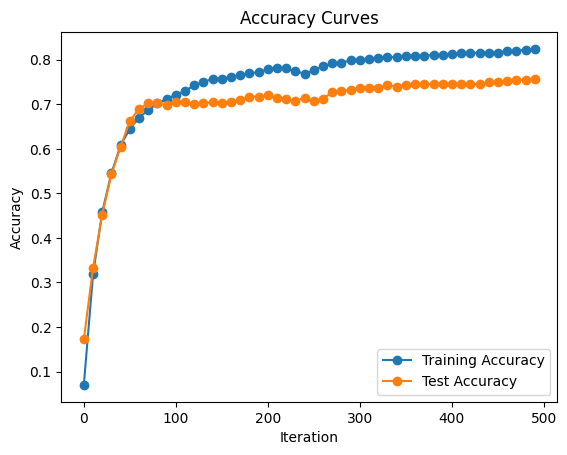

In [14]:
W1, b1, W2, b2, accuracy_vals_train, accuracy_vals_test = gradient_descent(X_train, Y_train, X_dev, Y_dev, 0.10, 500)
"""I am adding code to plot the accuracy curves as training iterates to examine whether the model is overfitting."""
plt.plot(range(0, 500, 10), accuracy_vals_train, marker='o', label='Training Accuracy')
plt.plot(range(0, 500, 10), accuracy_vals_test, marker='o', label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

In [15]:
# Validation Set Performance
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [16]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

0.7425

Prediction:  [5]
Label:  5


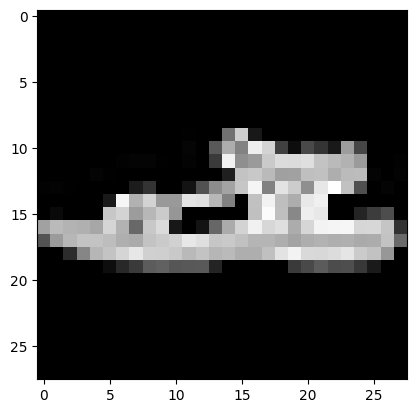

In [22]:
# Exploring samples
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

test_prediction(0, W1, b1, W2, b2)  # Predicts 1, label is 1 - CORRECT
test_prediction(1, W1, b1, W2, b2)  # Predicts 1, label is 1 - CORRECT
test_prediction(2, W1, b1, W2, b2)  # Predicts 4, label is 4 - CORRECT
test_prediction(50, W1, b1, W2, b2)  # Predicts 5, label is 5 - CORRECT

**Implementing 'Weight Decay' via L2 Regularization**

- 'Weight decay' is a regularization process which operates by adding a 'penalty' term (i.e. a regularization term) to the loss function of a neural net. This term is proportional to the sum of the squares of the model weights. It therefore 'pushes' the model to keep its weights small, which leads to the model being less complex and therefore less likely to overfit to noise or irrelevant details in the training images. 
- The process is controlled by a hyperparameter (usually called 'lambda'), which sets the strength of the regularization penalty. 
- During the training process, the regularization term is added to the gradients of the weights, which causes them to decay in magnitude if they are not meaningfully contributing to reducing loss in the model.

In order to add weight decay regularization to the model, I will need to modify the backward_prop, update_params, and gradient_descent functions to appropriately include and use the lambda term.

In [32]:
def backward_prop_reg(Z1, A1, A2, W1, W2, X, Y, lambda_val):
    """Adding regularization"""
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T) + lambda_val/m * W2  # Adding lambda term, dividing by m to average the gradient application, applying to weight matrix W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True) + lambda_val/m * b2  # Adding lambda term for db2
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T) + lambda_val/m * W1  # Adding lambda term, dividing by m to average the gradient application, applying to weight matrix W1
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True) + lambda_val/m * b1  # Adding regularization term for db1
    return dW1, db1, dW2, db2

def update_params_reg(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Using regularized terms"""
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

def gradient_descent_reg(X, Y, alpha, iterations, lambda_val):
    """Adding regularization"""    
    accuracy_vals = []

    W1, b1, W2, b2 = init_params()

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop_reg(Z1, A1, Z2, A2, W1, W2, X, Y, lambda_val)  # Adding regularization term to function call during gradient descent
        W1, b1, W2, b2 = update_params_reg(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, lambda_val)  # Adding regularization term to function call during gradient descent

        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(accuracy)
            accuracy_vals.append(accuracy)

    return W1, b1, W2, b2, accuracy_vals

Iteration:  0
0.10375
Iteration:  10
0.2875
Iteration:  20
0.465
Iteration:  30
0.55875
Iteration:  40
0.608125
Iteration:  50
0.63875
Iteration:  60
0.66375
Iteration:  70
0.67875
Iteration:  80
0.695625
Iteration:  90
0.7025
Iteration:  100
0.71125
Iteration:  110
0.720625
Iteration:  120
0.726875
Iteration:  130
0.73125
Iteration:  140
0.739375
Iteration:  150
0.741875
Iteration:  160
0.74375
Iteration:  170
0.75
Iteration:  180
0.754375
Iteration:  190
0.75875
Iteration:  200
0.7625
Iteration:  210
0.766875
Iteration:  220
0.77
Iteration:  230
0.773125
Iteration:  240
0.7775
Iteration:  250
0.78
Iteration:  260
0.78625
Iteration:  270
0.78625
Iteration:  280
0.78875
Iteration:  290
0.7925
Iteration:  300
0.795625
Iteration:  310
0.7975
Iteration:  320
0.8
Iteration:  330
0.8025
Iteration:  340
0.80625
Iteration:  350
0.809375
Iteration:  360
0.811875
Iteration:  370
0.813125
Iteration:  380
0.81625
Iteration:  390
0.818125
Iteration:  400
0.82125
Iteration:  410
0.823125
Iteration:

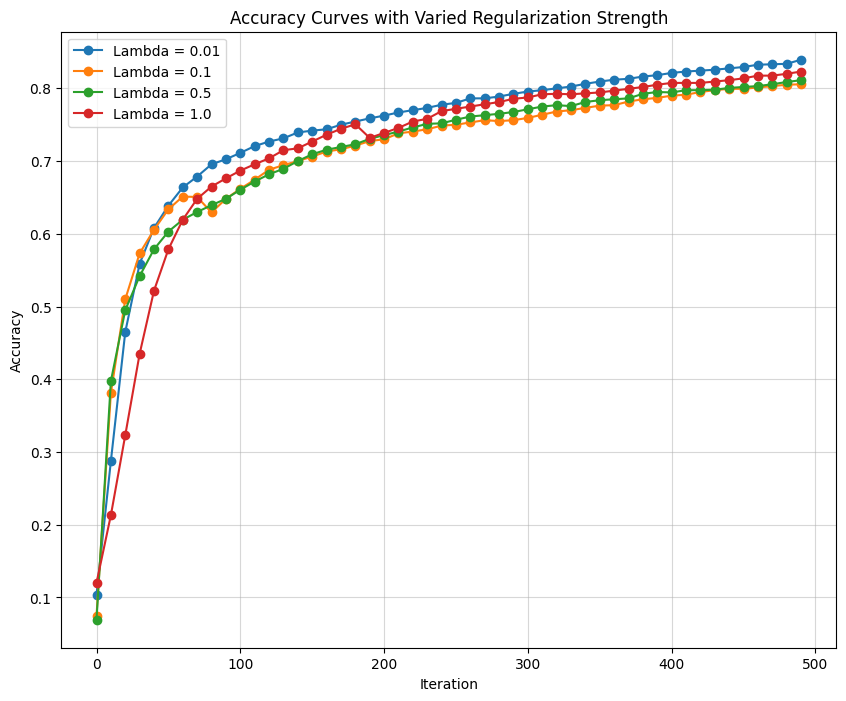

In [43]:
# Testing model with different weight decay regularization values
reg_vals = [0.01, 0.1, 0.5, 1.0]  # List of regularization values to assess

plt.figure(figsize=(10, 8))
for val in reg_vals:
    W1, b1, W2, b2, accuracy_vals_reg = gradient_descent_reg(X_train, Y_train, alpha=0.1, iterations=500, lambda_val=val)
    plt.plot(range(0, 500, 10), accuracy_vals_reg, marker='o', label=f'Lambda = {val}')
    
    # Print the final accuracy value for each regularization value
    print(f'Final accuracy for Lambda = {val}: {accuracy_vals_reg[-1]}')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves with Varied Regularization Strength')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

**Regularization Testing Results:**

After assessing a variety of regularization term strengths, using a lambda value of 0.01 seems to be a good choice. The curve never degrades, is entirely smooth without any sharp 'dips' (which was not true of the accuracy curve in the unregularized model), and it does not appear to plateau in a problematic manner. Additionally, adding regularization has not meaningfully impacted the accuracy of the model. In fact, the model accuracy on the training data is improved slightly, but that's likely to be coincidental rather than meaningful.

I therefore conclude that adding 'mild' regularization in the form of weight decay with a lambda value of 0.01 represents an improvement over my initial model's performance.